In [397]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import statsmodels.tsa.api as smt
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller

In [484]:
#Загрузим данные 
sales = pd.read_csv('/content/drive/My Drive/sql_.csv')
sales.head(10)

,ID_SKU,Week_ID,SKU_QTY,AVG_Discount,Checks_QTY,Stores_QTY,AVG_SKU_cost,Total_Cost
0,1,1,46747,0.000,12329,1663,156.9,13973925
1,1,2,43723,0.002,13026,1675,154.4,11239438
2,1,3,24285,0.002,7621,1475,154.8,6030625
3,1,4,76876,0.000,22606,1726,137.4,19071681
4,1,5,22371,0.001,7053,1513,148.3,5327759
5,1,6,26813,0.000,8743,1516,150.8,6690255
6,1,7,29162,0.000,9689,1558,147.0,7087620
7,1,8,26672,0.000,8891,1516,146.1,6902807
8,1,9,28054,0.000,9429,1503,145.4,6572828
9,1,10,28620,0.000,9079,1522,154.7,7205341


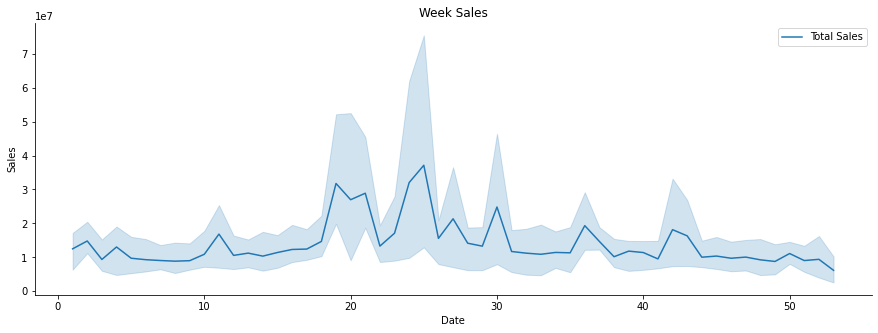

In [509]:
#Визуализируем целевой показатель продаж
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, label='Total Sales')
    
    #second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    #second.date = pd.to_datetime(second.date, format='%Y')
    #sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()
time_plot(sales, 'Week_ID', 'Total_Cost','Week Sales')

In [510]:
#Проверим временной ряд на стационарность с помощью теста Дики - Фулера
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    p = adf['p-value']   
    if p <= signif:
      print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")
        
adf_test(sales['Total_Cost']) #Ряд стационарен, поэтому данные можно использовать для обучения модели


Test Statistic           -2.863553
p-value                   0.049753
# Lags                    6.000000
# Observations          152.000000
Critical Value (1%)      -3.474121
Critical Value (5%)      -2.880750
Critical Value (10%)     -2.577013
dtype: float64
 Series is Stationary


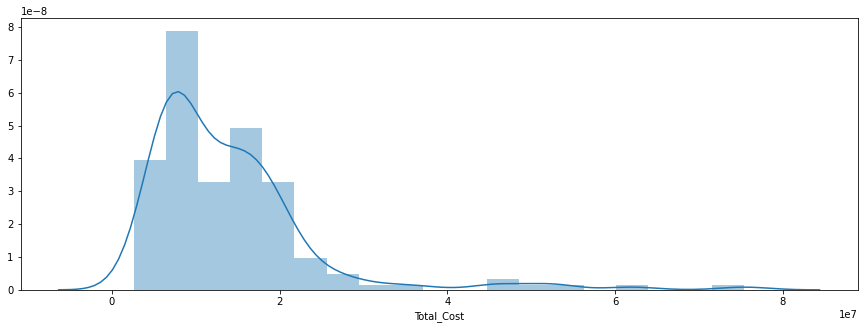

In [516]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sales['Total_Cost'],ax=ax)



In [405]:
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import pacf
#Поскольку проводится анализ временного ряда, создадим дополнительные предикторы из ретроспективных данных. 
#Применим функцию частичной автокорреляции для того, чтобы понять, какие данные подходят больше всего
def create_lag_features(y,col):
   
    scaler = StandardScaler()
    features = pd.DataFrame()
    
    partial = pd.Series(data=pacf(y, nlags=7))
    lags = list(partial[np.abs(partial) >= 0.2].index)
    
    df = pd.DataFrame()
    
    # avoid to insert the time series itself
    lags.remove(0)
    
    for l in lags:
        df[f"lag_{l}"+'_'+col] = y.shift(l)
    
    features = pd.DataFrame(df[df.columns],
                            columns=df.columns)
    features.index = y.index
    
    return features

In [519]:
#Построим датасеты по каждому товару с и внесем в них данные из прошлого, чтобы получить возможность использовать модель
lag_df = sales

features = create_lag_features(stationary_df['Total_Cost'],'Total_Cost')
lag_df = lag_df.join(features)
#Сдвигаем показатели "Количество товара", "Средняя стоимость товара" и "и "Количество магазинов" на один шаг вперед, 
#так как мы не можем их использовать для предсказания текущего объема продаж
SKU_1 = lag_df.loc[lag_df['ID_SKU']==1].drop('ID_SKU',axis=1)
SKU_1[['SKU_QTY','Checks_QTY','Stores_QTY']]=SKU_1[['SKU_QTY','Checks_QTY','Stores_QTY']].shift(1)
SKU_1 = SKU_1.dropna()
SKU_2 = lag_df.loc[lag_df['ID_SKU']==2536564].drop('ID_SKU',axis=1)
SKU_2[['SKU_QTY','Checks_QTY','Stores_QTY']]=SKU_2[['SKU_QTY','Checks_QTY','Stores_QTY']].shift(1)
SKU_2 = SKU_2.dropna()
SKU_3 = lag_df.loc[lag_df['ID_SKU']==951398].drop('ID_SKU',axis=1)
SKU_3[['SKU_QTY','Checks_QTY','Stores_QTY']]=SKU_3[['SKU_QTY','Checks_QTY','Stores_QTY']].shift(1)
SKU_3 = SKU_3.dropna()
SKU_1.head(10)

,Week_ID,SKU_QTY,AVG_Discount,Checks_QTY,Stores_QTY,AVG_SKU_cost,Total_Cost,lag_1_Total_Cost,lag_2_Total_Cost,lag_3_Total_Cost,lag_4_Total_Cost,lag_5_Total_Cost,lag_6_Total_Cost,lag_7_Total_Cost
7,8,29162.0,0.0,9689.0,1558.0,146.1,6902807,7087620.0,6690255.0,5327759.0,19071681.0,6030625.0,11239438.0,13973925.0
8,9,26672.0,0.0,8891.0,1516.0,145.4,6572828,6902807.0,7087620.0,6690255.0,5327759.0,19071681.0,6030625.0,11239438.0
9,10,28054.0,0.0,9429.0,1503.0,154.7,7205341,6572828.0,6902807.0,7087620.0,6690255.0,5327759.0,19071681.0,6030625.0
10,11,28620.0,0.0,9079.0,1522.0,132.8,25378095,7205341.0,6572828.0,6902807.0,7087620.0,6690255.0,5327759.0,19071681.0
11,12,98094.0,0.0,29814.0,1728.0,142.5,8759655,25378095.0,7205341.0,6572828.0,6902807.0,7087620.0,6690255.0,5327759.0
12,13,36643.0,0.0,11777.0,1625.0,141.3,7062437,8759655.0,25378095.0,7205341.0,6572828.0,6902807.0,7087620.0,6690255.0
13,14,30374.0,0.0,10306.0,1579.0,140.6,6076140,7062437.0,8759655.0,25378095.0,7205341.0,6572828.0,6902807.0,7087620.0
14,15,26155.0,0.0,8890.0,1507.0,147.1,6916585,6076140.0,7062437.0,8759655.0,25378095.0,7205341.0,6572828.0,6902807.0
15,16,28117.0,0.0,9299.0,1567.0,139.3,8600235,6916585.0,6076140.0,7062437.0,8759655.0,25378095.0,7205341.0,6572828.0
16,17,37525.0,0.0,12735.0,1612.0,139.1,9268914,8600235.0,6916585.0,6076140.0,7062437.0,8759655.0,25378095.0,7205341.0


In [ ]:
#Сформируем по каждому товару тренировочный и тестовый датасеты
SKU_1_train_X, SKU_1_train_y, SKU_1_test_X, SKU_1_test_y = SKU_1[:-10].drop('Total_Cost',axis=1),SKU_1['Total_Cost'][:-10], SKU_1[-10:].drop('Total_Cost',axis=1), SKU_1['Total_Cost'][-10:]
SKU_2_train_X, SKU_2_train_y, SKU_2_test_X, SKU_2_test_y = SKU_2[:-10].drop('Total_Cost',axis=1), SKU_2['Total_Cost'][:-10], SKU_2[-10:].drop('Total_Cost',axis=1), SKU_2['Total_Cost'][-10:]
SKU_3_train_X, SKU_3_train_y, SKU_3_test_X, SKU_3_test_y = SKU_3[:-10].drop('Total_Cost',axis=1), SKU_3['Total_Cost'][:-10], SKU_3[-10:].drop('Total_Cost',axis=1), SKU_3['Total_Cost'][-10:]


In [ ]:
#Реализуем функцию для расчета MAPE, который понадобится нам для оценки результатов
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 1 - np.sum(np.abs(y_true - y_pred) / np.sum(y_true)) 

In [488]:
#Обучим модель и сделаем предсказания с помощью градиентного бустинга
model = XGBRegressor(
    max_depth=8,
    n_estimators=500, 
    colsample_bytree=1, 
    subsample=1, 
    eta=0.3,    
    seed=42)


model.fit(SKU_1_train_X, SKU_1_train_y)
pred_1 = model.predict(SKU_1_test_X)
MAPE_1 = get_mape(SKU_1_test_y,pred_1)
model.fit(SKU_2_train_X, SKU_2_train_y)
pred_2 = model.predict(SKU_2_test_X)
MAPE_2 = get_mape(SKU_2_test_y,pred_2)
model.fit(SKU_3_train_X, SKU_3_train_y)
pred_3 = model.predict(SKU_3_test_X)
MAPE_3 = get_mape(SKU_3_test_y,pred_3)
print('MAPE of SKU_ID #1 = ', str(MAPE_1),
      '\nMAPE of SKU_ID #2536564 = ',str(MAPE_2),
      '\nMAPE of SKU_ID #951398 = ',str(MAPE_3))

[18:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAPE of SKU_ID #1 =  0.24684891168680012 
MAPE of SKU_ID #2536564 =  0.9007101965079253 
MAPE of SKU_ID #951398 =  0.9016477270377643


In [507]:
#Соберем результат в единый датафрейм 
results = pd.concat([pd.DataFrame({'ID_SKU':1,'Week_ID':SKU_1_test_X['Week_ID'],'Forecast':pred_1, 'Fact':SKU_1_test_y}),
          pd.DataFrame({'ID_SKU':2536564,'Week_ID':SKU_2_test_X['Week_ID'],'Forecast':pred_2, 'Fact':SKU_2_test_y}),
          pd.DataFrame({'ID_SKU':951398,'Week_ID':SKU_3_test_X['Week_ID'],'Forecast':pred_3, 'Fact':SKU_3_test_y})])
results['ABS Error'] = results['Forecast'] - results['Fact']
results['Accuracy']  = results['Forecast']/results['Fact']
results.to_excel('/content/results.xlsx')
